In [5]:
# 파이썬≥3.5 필수
import sys
assert sys.version_info >= (3, 5)
# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os
# 깔끔한 그래프 출력을 위해 %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
from matplotlib import font_manager, rc
import platform
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

mpl.rcParams['axes.unicode_minus'] = False
# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한
%precision 3
# 그래픽 출력을 조금 더 고급화하기 위한 라이브러리
import seaborn as sns

#과학 기술 통계 라이브러리
import scipy as sp
from scipy import stats
# 사이킷런 ≥0.20 필수 : 0.20에서 데이터 변환을 위한 Transformer클래스가 추가됨
import sklearn
assert sklearn.__version__ >= "0.20"

# 데이터를 분할할 때 동일한 분할을 만들기 위해서
# 모델을 만드는 작업을 여러 번에 걸쳐서 하는 경우 시드가 변경이 되서 훈련용 데이터가
# 자주 변경이 되면 결국 모든 데이터를 가지고 모델을 생성하는 결과
# Overfit이 될 가능성이 높아짐
np.random.seed(42)


## 투표기반 분류기의 성능 확인

In [6]:
# 데이터 생성
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X[0:5])
print(y[0:5])
# y는 0과1이고 X는 2개의 피처를 가지고 있음



[[ 0.831 -0.259]
 [ 1.185  0.92 ]
 [ 1.164 -0.456]
 [-0.024  1.086]
 [ 0.481  1.509]]
[1 0 1 0 0]


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

voting_clf.fit(X_train, y_train)



VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [8]:
# 각 모델의 정확도 확인
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,"정확도 :", accuracy_score(y_test, y_pred))

LogisticRegression 정확도 : 0.864
RandomForestClassifier 정확도 : 0.896
SVC 정확도 : 0.896
VotingClassifier 정확도 : 0.912


In [9]:
# 간접 투표 방식
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,"정확도 : ", accuracy_score(y_test, y_pred))


LogisticRegression 정확도 :  0.864
RandomForestClassifier 정확도 :  0.896
SVC 정확도 :  0.896
VotingClassifier 정확도 :  0.92


## Bagging을 이용한 앙상블

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

from sklearn.metrics import accuracy_score
print("정확도 : ", accuracy_score(y_test, y_pred))

정확도 :  0.904


In [13]:
# oob 평가
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, max_samples=100,
    bootstrap=True, oob_score=True, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.925

## 배깅과 랜덤포레스트

In [14]:
#배깅
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)


In [16]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(np.sum(y_pred == y_pred_rf) / len(y_pred))
#결과는 1.0 : bog_clf와 rnd_clf가 예측한 결과가 정확히 일치

1.0


## 타이타닉 데이터에 RandomForest 적용

In [17]:
df = sns.load_dataset('titanic')
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [18]:
# 결측치 처리

# NaN값이 많은 deck 열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck', 'embark_town'], axis=1)  

# age 열에 나이 데이터가 없는 모든 행을 삭제 - age 열(891개 중 177개의 NaN 값)
rdf = rdf.dropna(subset=['age'], how='any', axis=0)  

# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()   
rdf['embarked'].fillna(most_freq, inplace=True)
rdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    714 non-null    int64   
 1   pclass      714 non-null    int64   
 2   sex         714 non-null    object  
 3   age         714 non-null    float64 
 4   sibsp       714 non-null    int64   
 5   parch       714 non-null    int64   
 6   fare        714 non-null    float64 
 7   embarked    714 non-null    object  
 8   class       714 non-null    category
 9   who         714 non-null    object  
 10  adult_male  714 non-null    bool    
 11  alive       714 non-null    object  
 12  alone       714 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(4)
memory usage: 63.6+ KB


In [19]:
#순서가 없는 범주형 데이터를 원핫 인코딩

# 분석에 활용할 열(속성)을 선택 
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]

# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf.drop(['sex', 'embarked'], axis=1, inplace=True)

print(ndf.head())

   survived  pclass   age  sibsp  parch  female  male  town_C  town_Q  town_S
0         0       3  22.0      1      0       0     1       0       0       1
1         1       1  38.0      1      0       1     0       1       0       0
2         1       3  26.0      0      0       1     0       0       0       1
3         1       1  35.0      1      0       1     0       0       0       1
4         0       3  35.0      0      0       0     1       0       0       1


In [20]:
# 피처와 타겟을 분리
X=ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S']]  #독립 변수 X
y=ndf['survived']                      #종속 변수 Y

# 정규화
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
print(X[0:5])

[[ 0.911 -0.53   0.525 -0.506 -0.759  0.759 -0.472 -0.202  0.533]
 [-1.476  0.572  0.525 -0.506  1.317 -1.317  2.12  -0.202 -1.876]
 [ 0.911 -0.255 -0.552 -0.506  1.317 -1.317 -0.472 -0.202  0.533]
 [-1.476  0.365  0.525 -0.506  1.317 -1.317 -0.472 -0.202  0.533]
 [ 0.911  0.365 -0.552 -0.506 -0.759  0.759 -0.472 -0.202  0.533]]


In [21]:
# 훈련 데이터와 테스트 데이터 분할

# 데이터가 랜덤하게 배치되어 있다면 분할을 할 때 순서대로 앞에서 일정 부분은
# 훈련 데이터로 사용하고 일정 부분은 테스트 데이터로 할당하면 됨

# 타겟의 비율을 고려
# 타겟의 비율이 고르지 않다면 여러가지 고려
# 층화 추출이나 oversampling 이나 undersampling
# 이상치 탐지에서 이 부분이 항상 고려 대상

# 훈련 데이터의 비율 - 일반적으로 0.7이나 0.8을 많이 사용

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



0    424
1    290
Name: survived, dtype: int64

In [22]:
# 모델을 만들어서 훈련
# 불순도 지표는 entropy - 기본은 gini 계수
# 트리의 개수는 25개
# 코어는 최대한 사용
# criterion을 entropy로 설정하면 엔트로피 불순도를 사용

forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=25, 
                                random_state=42,
                                n_jobs=-1)
forest.fit(X_train, y_train)




RandomForestClassifier(criterion='entropy', n_estimators=25, n_jobs=2,
                       random_state=1)

In [23]:
# 평가 지표 확인
# test data를 가지고 y_hat을 예측 (분류) 
y_hat = forest.predict(X_test) 

print(y_hat[0:10])
print(y_test.values[0:10])


[0 0 1 0 0 1 1 0 0 0]
[0 0 1 0 0 1 1 1 0 0]


In [27]:
# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
tree_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(tree_matrix)

# 정확도 계산
print(np.sum(tree_matrix))
print((tree_matrix[0,0] + tree_matrix[1,1])/np.sum(tree_matrix))


[[106  19]
 [ 27  63]]
215
0.786046511627907


In [28]:
# 모형 성능 평가 - 평가지표 계산
tree_report = metrics.classification_report(y_test, y_hat)            
print(tree_report)

              precision    recall  f1-score   support

           0       0.80      0.85      0.82       125
           1       0.77      0.70      0.73        90

    accuracy                           0.79       215
   macro avg       0.78      0.77      0.78       215
weighted avg       0.78      0.79      0.78       215



[0.139 0.453 0.068 0.054 0.146 0.104 0.013 0.007 0.017]


(-1.000, 9.000)

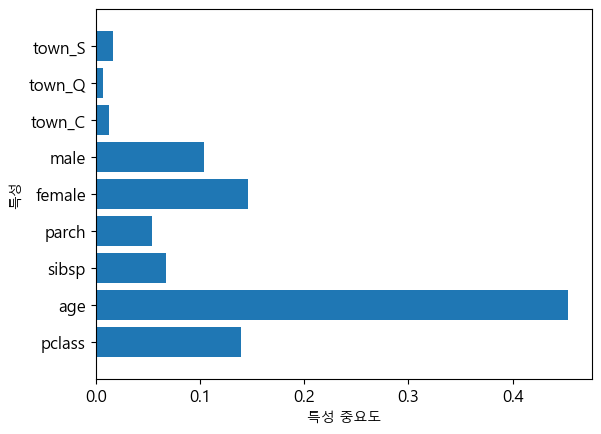

In [30]:
# 특성 중요도 확인
print(forest.feature_importances_)
# 중요도가 나오긴 하지만 숫자만 나와서 알아보기 힘듦

n_features = X.data.shape[1]
plt.barh(np.arange(n_features), forest.feature_importances_, align='center')
plt.yticks(np.arange(n_features), ['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S'])
plt.xlabel("특성 중요도")
plt.ylabel("특성")
plt.ylim(-1, n_features)

In [32]:
## AdaBoost
from sklearn.ensemble import AdaBoostClassifier
#algorithm 은 확률을 계산할 수 있으면 SAMME.R 이고 없으면 SAMME
#learning_rate는 학습률
#학습률이 너무 크면 최적회되지 않을 가능성이 높아지고 너무 작으면 훈련 속도가 느려지고 overfitting 될 가능성이 발생

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

y_hat = ada_clf.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[0 1 1 0 1 0 1 1 0 0]
[0 0 1 0 0 1 1 1 0 0]


In [35]:
%%time
#주피터 노트북에서 수행 시간 측정할 때 사용
## Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train , y_train)
y_hat = gb_clf.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

# 오차 행렬

gb_matrix = metrics.confusion_matrix(y_test, y_hat)
print(gb_matrix)

print((gb_matrix[0, 0] + gb_matrix[1, 1]) / np.sum(gb_matrix))


[0 1 1 0 0 1 1 1 0 0]
[0 0 1 0 0 1 1 1 0 0]
[[106  19]
 [ 25  65]]
0.7953488372093023
CPU times: total: 109 ms
Wall time: 109 ms


In [36]:
%%time
# 하이퍼 파라미터 튜닝 - 시간이 있을 때는 여러 값을 설정
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : [100, 500],
    'learning_rate' : [0.05, 0.1]
}

grid_cv = GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=1)
grid_cv.fit(X_train, y_train)
print("최적의 파라미터 : ", grid_cv.best_params_)
print("최적의 정확도 : ", grid_cv.best_score_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
최적의 파라미터 :  {'learning_rate': 0.05, 'n_estimators': 100}
최적의 정확도 :  0.7895903614457831
CPU times: total: 2.3 s
Wall time: 2.32 s


In [37]:
# 튜닝의 결과로 예측
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print(gb_accuracy)

0.8372093023255814


In [40]:
!pip install xgboost

     ---------------------------------------- 70.9/70.9 MB 8.8 MB/s eta 0:00:00


In [41]:
import xgboost as xgb